<a href="https://colab.research.google.com/github/lvb86/PD_LSTM_GA/blob/main/code/LSTM_GEN_e32_p16_BR_res_2013_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Algoritimo Genético Para Sintonia de LSTM

Aplicado a Scenário:
* BR padrão 32 épocas, pop = 16
* Período 2013-2018

##_Entradas_

* ~IBCBR~
* ~IBOV~
* ~IPCA~
* ~Obitos~
* Clima 
* Consumo Resenha EPE:
    - Comercial
    - Industrial
    - Residencial
    - Outros



##Declarações Globais

In [1]:
!pip install -U scikit-learn 

     |████████████████████████████████| 22.3 MB 86 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
if 0:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
import matplotlib.pyplot        as plt
import matplotlib.ticker        as ticker
import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import tensorflow               as tf
import os
import glob
import shutil
import random                   as rn
import math

from datetime                   import datetime, timedelta
from sklearn.model_selection    import train_test_split,RepeatedStratifiedKFold 
from sklearn.preprocessing      import MinMaxScaler
from sklearn.preprocessing      import StandardScaler        #Normalização dos dados
from sklearn.pipeline           import make_pipeline         #Pipe Line
from sklearn.neural_network     import MLPRegressor
from sklearn.metrics            import mean_absolute_percentage_error

from sklearn.model_selection    import GridSearchCV
#from sklearn.svm import SVC
from tensorflow                 import keras
from tensorflow.keras           import Sequential, layers, callbacks
from tensorflow.keras           import backend as K
from tensorflow.keras.layers    import Dense, LSTM, Dropout, Bidirectional

seed = 170696
sns.set()
sns.set_theme()

#### Path

In [4]:
path  = '/tmp/'
patha = path  + 'arcaBR_sn/'
pathb = patha + 'bkp/'
urla  = patha + 'arca.csv'

prefGo    = 'https://docs.google.com/uc?export=download&id='

urld        = prefGo + '1oN489-qxjCNJwUlLrO6sAUSozGzTaG7C'
urlibc      = prefGo + '1QrbgeR7TyHbcNx3l-ke2RD33kn0p0BgY'
urlTabnet   = prefGo + '1z1vn0D9Efnl-wRO_tYDZafZhLGRrPwc0'
urlEPE      = prefGo + '1Qb8aIVyaUpvSn_l6-tbDRtIkUv5RANvN'
urlclima    = prefGo + '1m11IcEh6gNRZC_uuAozBvQp1Ji4c0YvQ'
urlibov     = prefGo + '1S2SQ98qk3V52LnYde04QR2k-X8VhZ_n6'
urlipca     = prefGo + '1l6wRFAprymsQoVoNqAvv1g2EMN2tmVMa'

### Randon Freeze

In [5]:
def imports():
    import matplotlib.pyplot        as plt
    import matplotlib.ticker        as ticker
    import numpy                    as np
    import pandas                   as pd
    import seaborn                  as sns
    import tensorflow               as tf
    import os
    import glob
    import shutil
    import random                   as rn
    import math

    from datetime                   import datetime, timedelta
    from sklearn.model_selection    import train_test_split,RepeatedStratifiedKFold 
    from sklearn.preprocessing      import MinMaxScaler
    from sklearn.preprocessing      import StandardScaler        #Normalização dos dados
    from sklearn.pipeline           import make_pipeline         #Pipe Line
    from sklearn.neural_network     import MLPRegressor
    from sklearn.metrics            import mean_absolute_percentage_error

    from sklearn.model_selection    import GridSearchCV
    #from sklearn.svm import SVC
    from tensorflow                 import keras
    from tensorflow.keras           import Sequential, layers, callbacks
    from tensorflow.keras           import backend as K
    from tensorflow.keras.layers    import Dense, LSTM, Dropout, Bidirectional

    seed = 170696
    sns.set()
    sns.set_theme()

In [6]:
# Utilizando o essa foi a unica maneira encontrada para congelar o randon e 
# garantir a reprodutibilidade do modelo 

def reset_seed(seed,keras=False, verbose = False):
    imports()
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed)
    rn.seed(seed)

    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.compat.v1.set_random_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

def set_seed_rand(verbose = False):
    
    from datetime import datetime

    dt_seg_now = datetime.now().strftime("%S")
    #print("\t\tSEED =", dt_seg_now)	
    nseed = int(dt_seg_now)
    os.environ['PYTHONHASHSEED'] = str(nseed)
    np.random.seed(nseed)
    rn.seed(nseed)
    if verbose: print("\t\tSEED =", dt_seg_now)	


## Dados

In [7]:
anoIni = 2013
anoFim = 2018

In [8]:
ibov = pd.read_csv(urlibov, sep=';', decimal=',', thousands='.', skiprows=1, skip_blank_lines=True, header=0, encoding='Latin-1')

ibov['mm'] = '0' + ibov['Mês'].astype(str)
ibov['Ano Mês'] = ibov.Ano.astype(str) + '-' +ibov.mm.str[-2:]
ibov = ibov[(ibov.Ano.astype(int) >= anoIni )*(ibov.Ano.astype(int) <= anoFim)]
ibov.rename(columns={'Valor':'ibov'}, inplace = True)
ibov.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,Mês,Ano,ibov,mm,Ano Mês
12,1,2013,59761.49,01,2013-01
13,2,2013,57424.29,02,2013-02


In [9]:
ibov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 12 to 83
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Mês      72 non-null     int64  
 1   Ano      72 non-null     int64  
 2   ibov     72 non-null     float64
 3   mm       72 non-null     object 
 4   Ano Mês  72 non-null     object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.4+ KB


In [10]:
ibcbr = pd.read_csv(urlibc, sep =';' ,decimal=',',parse_dates=True, dayfirst=True,encoding='UTF8', index_col='data' )
ibcbr = ibcbr[(ibcbr.index.year >= anoIni )*(ibcbr.index.year <= anoFim)]
ibcbr.shape

(72, 1)

In [11]:
ibcbr['Ano Mês']= ibcbr.index.year.astype(str) +'-'+ ('0' + ibcbr.index.month.astype(str)).str[-2:]
ibcbr = ibcbr.rename(columns={'valor':'ibcbr'})

In [12]:
ipca = pd.read_csv(urlipca, sep =';' ,decimal=',',parse_dates=True, dayfirst=True,encoding='UTF8', index_col='data' )
ipca = ipca[(ipca.index.year >= anoIni )*(ipca.index.year <= anoFim)]
ipca['Ano Mês'] = ipca.index.year.astype(str)+'-'+ ('0' + ipca.index.month.astype(str)).str[-2:]
ipca.rename(columns={'valor':'ipca'}, inplace = True)
ipca.shape

(72, 2)

In [13]:
tabnet = pd.read_csv(urlTabnet, sep =';', decimal=',', skiprows=3, skipfooter=6, encoding='latin_1')
tabnet['Ano/mês processamento'] = tabnet['Ano/mês processamento'].str.replace('..','',regex=False)
tabnet = tabnet[tabnet['Ano/mês processamento'].str.len() >= 6]
tabnet['Ano'] = tabnet['Ano/mês processamento'].str[-4:]
tabnet['Mês'] = tabnet['Ano/mês processamento'].str[:-5]
tabnet['Mês'] = tabnet['Mês'].str.strip()
mapmes = {'Janeiro':'01', 'Fevereiro':'02', 'Março':'03', 'Abril':'04', 'Maio':'05', 'Junho':'06',
 'Julho':'07', 'Agosto':'08', 'Setembro':'09', 'Outubro':'10', 'Novembro':'11', 'Dezembro':'12'}
tabnet['mm'] = tabnet['Mês'].map(mapmes)
tabnet.drop(columns = 'Ano/mês processamento')
tabnet['Ano Mês'] = tabnet.Ano +'-'+ tabnet.mm 
tabnet = tabnet.rename(columns = {'Total': 'BR'})
obtosBR = tabnet[tabnet.Ano.astype(int) <= anoFim][['Ano Mês', 'BR']]
obtosBR = obtosBR.rename(columns = {'BR':'Obitos'})
obtosBR.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


(72, 2)

In [14]:
pd.read_csv(urlEPE)

,Ano,Mes,Total,Norte,Nordeste,Sudeste,Sul,CentoOeste,Ano Mês,Setor
0,2021,1,13597745.91,830281.77,2758984.88,6571311.64,2260371.61,1176796.01,2021-01,Residencial
1,2021,2,12816225.52,803678.00,2619758.51,6192199.70,2107756.15,1092833.16,2021-02,Residencial
2,2021,3,13204377.21,820022.59,2727749.08,6321507.66,2190795.20,1144302.68,2021-03,Residencial
3,2021,4,13295462.41,864941.75,2774864.34,6349461.85,2109543.78,1196650.69,2021-04,Residencial
4,2021,5,11916732.03,859232.55,2536646.39,5591479.32,1867454.95,1061918.82,2021-05,Residencial
...,...,...,...,...,...,...,...,...,...,...
835,2004,8,3892772.35,212999.10,726332.07,1833404.77,714015.51,406020.90,2004-08,Outros
836,2004,9,4045925.14,214694.08,766592.08,1890523.79,738705.75,435409.44,2004-09,Outros
837,2004,10,4226884.42,218705.12,798723.62,2053894.16,734053.68,421507.84,2004-10,Outros
838,2004,11,4054988.32,214175.36,813985.52,1908302.43,752820.39,365704.62,2004-11,Outros


In [15]:
dfEPE = pd.read_csv(urlEPE)
dfEPE = dfEPE[(dfEPE.Ano >= anoIni) & (dfEPE.Ano <= anoFim)]
dfEPE = dfEPE.pivot(index = ['Ano Mês','Mes'], columns='Setor',values = 'Total')
dfEPE['Consumo'] = dfEPE.Comercial + dfEPE.Residencial + dfEPE.Comercial + dfEPE.Outros

In [16]:
clima = pd.read_csv(urlclima, index_col=False)

In [17]:
df = dfEPE.reset_index()
df = pd.merge(df,ibcbr[['Ano Mês','ibcbr']],left_on='Ano Mês',right_on='Ano Mês')
df = pd.merge(df,ibov[['Ano Mês','ibov']],left_on='Ano Mês',right_on='Ano Mês')
df = pd.merge(df,obtosBR[['Ano Mês','Obitos']],left_on='Ano Mês',right_on='Ano Mês')
df = pd.merge(df,ipca[['Ano Mês','ipca']],left_on='Ano Mês',right_on='Ano Mês')
df = pd.merge(df,clima.reset_index()[['Ano Mês','Dias com Precipitação','Precipitação', 'Pressão', 'Temperatura', 'Vento Máx', 'Vento Méd' ]],              left_on='Ano Mês',right_on='Ano Mês')


In [18]:
df.head(3)

,Ano Mês,Mes,Comercial,Industrial,Outros,Residencial,Consumo,ibcbr,ibov,Obitos,ipca,Dias com Precipitação,Precipitação,Pressão,Temperatura,Vento Máx,Vento Méd
0,2013-01,1,7202468.0,14369522.0,5869934.74,10924885.0,31199755.74,139.32,59761.49,36585,0.65,24.310968,246.816448,910.844015,23.393484,7.138098,2.168308
1,2013-02,2,7035408.0,14790315.0,5705399.72,10474529.0,30250744.72,136.14,57424.29,34110,0.55,17.533548,185.409741,911.280033,23.715527,6.971059,2.085319
2,2013-03,3,7146581.0,15148031.0,5790583.55,10356996.0,30440741.55,148.01,56352.09,34472,0.46,21.150809,208.611393,912.630237,23.309656,6.971698,1.993334


In [19]:
df.columns

Index(['Ano Mês', 'Mes', 'Comercial', 'Industrial', 'Outros', 'Residencial',
       'Consumo', 'ibcbr', 'ibov', 'Obitos', 'ipca', 'Dias com Precipitação',
       'Precipitação', 'Pressão', 'Temperatura', 'Vento Máx', 'Vento Méd'],
      dtype='object')

In [20]:

df['mes_sin'] = np.sin(df['Mes']*2*np.pi/12)
df['mes_cos'] = np.cos(df['Mes']*2*np.pi/12)
d = df.drop(columns=['Ano Mês', 'Mes']).reset_index()
Ycolumns = ['Consumo', 'Comercial', 'Industrial', 'Residencial', 'Outros']
#Xcolumns = [*{*d.columns.to_list()}-{*Ycolumns,'index','level_0','ibcbr', 'ibov', 'Obitos', 'ipca'}]
Xcolumns = [*{*d.columns.to_list()}-{*Ycolumns,'index','level_0','ibcbr', 'ibov', 'Obitos','ipca'}]

print('X\n',len(Xcolumns),'\n', Xcolumns)
print('Y\n',len(Ycolumns),'\n', Ycolumns)

X
 8 
 ['mes_sin', 'Vento Máx', 'Dias com Precipitação', 'Vento Méd', 'mes_cos', 'Temperatura', 'Precipitação', 'Pressão']
Y
 5 
 ['Consumo', 'Comercial', 'Industrial', 'Residencial', 'Outros']


## Funções

#### Train Test Split

In [21]:
df.shape[0]

72

In [22]:
def TrainTestData(col_i):
    lin = df.shape[0]
    lin_train = lin - 12
    X = d[Xcolumns]
    y = d[Ycolumns]
    y = y.iloc[:,col_i]
    # Different scaler for input and output
    scaler_x = MinMaxScaler(feature_range = (0,1))
    scaler_y = MinMaxScaler(feature_range = (0,1))
    #print(2)
    # Fit the scaler using available training data
    input_scaler = scaler_x.fit(X)
    X_norm = input_scaler.transform(X)
    #print('y_shape= ',y.shape)
    #print('y_shape= ',len(y.shape))
    if len(y.shape) == 1:
       # print('..reshape')
        output_scaler = scaler_y.fit(y.to_numpy().reshape(-1,1))
        y_norm = output_scaler.transform(y.to_numpy().reshape(-1,1))
    else:
        output_scaler = scaler_y.fit(y)
        y_norm = output_scaler.transform(y)
        
    X_train = X_norm[:lin_train]
    y_train = y_norm[:lin_train]

    X_test = X_norm[lin_train:]
    y_test = y_norm[lin_train:]

    y_real = y[lin_train:]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    #print("Dimensões X: ",'X_train',X_train.shape,'X_test', X_test.shape)
    #print("Dimensões Y: ",'Y_train',y_train.shape,'Y_test', y_test.shape)

    shape_in = X_train.shape[2]
    shape_out = y_train.shape[1]

    return shape_in, shape_out, X_train, y_train, X_test, y_test, y_real, input_scaler, output_scaler

In [23]:
def TrainTestData_old(verbose=False):
    lin = df.shape[0]
    lin_train = lin - 12
    X = d[Xcolumns]
    y = d[Ycolumns]
    # Different scaler for input and output
    scaler_x = MinMaxScaler(feature_range = (0,1))
    scaler_y = MinMaxScaler(feature_range = (0,1))

    # Fit the scaler using available training data
    input_scaler = scaler_x.fit(X)
    #output_scaler = scaler_y.fit(y.to_numpy().reshape(-1,1))
    output_scaler = scaler_y.fit(y)

    # Apply the scaler to training data
    X_norm = input_scaler.transform(X)
    #y_norm = output_scaler.transform(y.to_numpy().reshape(-1,1))
    y_norm = output_scaler.transform(y)

    X_train = X_norm[:lin_train]
    y_train = y_norm[:lin_train]

    X_test = X_norm[lin_train:]
    y_test = y_norm[lin_train:]

    y_real = y[lin_train:]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    if verbose:
        print("Dimensões X: ",'X_train',X_train.shape,'X_test', X_test.shape)
        print("Dimensões Y: ",'Y_train',y_train.shape,'Y_test', y_test.shape)

    shape_in = X_train.shape[2]
    shape_out = y_train.shape[1]

    return X,y,input_scaler,output_scaler,X_train,y_train,X_test,y_test,y_real,shape_in, shape_out

###Genéticas

#### Inicia Populacão

In [24]:
def inicializa_populacao(pop_tamanho, n_genes, limites):
    """
    Inicializa a população de acordo com o tamanho da população
    e número de genes.

    param pop_tamanho:     Número de individuos na população
    param n_genes:         Número de genes (Variáveis) no problema
    param limites:         Tupla contendo o número mínimo e máximo permitido  
    return:                Um array numpy com a população iniciada 
                           randomicamente
    """

    pop0 = np.random.randint(
      limites[0], limites[1], size=(pop_tamanho, n_genes)
    )
    pop=[]
    for e, i in enumerate(pop0):
        if np.sum(i) == 0:
            n = np.random.randint(limites[0]+1, limites[1], size=(1, n_genes))
            #print(e,i,n)
            pop.append(n)
        else:    
            pop.append(i)
    return pop

####Função de aptidão

In [25]:
def rede_desc(bl_list, unit_list, drop_list):
    '''
    Retorna descrição gráfica da Rede

    '''
    dic_bl = {0: 'LSTM', 1:'BILSTM'}
    desc = '->'
    for e,i in enumerate(unit_list):
        if i >0:
            if e < 2:
                desc+=(f'{dic_bl[bl_list[e]]}')   
            else:
                desc+=('MLP')
            desc+=(f'({unit_list[e]})->')
            if e < 5:
                desc+=(f'd({drop_list[e]})->')
    return desc

In [26]:
def decode_gen(chave, verbose = False):
    '''
    Recebe chave genética e retorna estrutura da rede 
    considerando arquitetura predefinida 

            Tipo---\ Dropout -----------------\ Neurônios-------------------\ 
            B|L  B|L  D12  D23  D34  D45  D56  NL1  NL2  NL3  NL4  NL5  NL6              
    chave =[ p01, p02, p03, p04, p05, p06, p07, p07, p08, p09, p10, p11, p12]
            2|1  2|1  2|1  2|1  2|1

    Tipo      -> se par BILSTM se não LSTM
    Dropout   -> If 0 = 0 
                Else
                    Se par 0.2 senão 0.1 
    Neurônios -> If 0 desetiva layer e dropout seguinte 
                Else numero de neurônios da camada                
    '''

    bl_list = []
    drop_list = []
    unit_list = []
    Lini = 0
    Lcount = 0

    for i in range(7,13):
        if chave[i] >0:
            ini = i-6
            break
    for i in range(7,13):
        if chave[i] >0:
            Lcount +=1
    if verbose: print(f'\tN Layers = {Lcount}')
    else: print('.',sep='',end='')

    for i in range(2):
        if chave[i] % 2 == 0:
            bl_list.append(1)
        else:
            bl_list.append(0)

    for i in range(2,7):
        if chave[i] ==0:
            drop_list.append(0)
        else:
            if chave[i] % 2 == 0:
                drop_list.append(0.2)
            else: 

                drop_list.append(0.1)

    for i in range(7,13):
        unit_list.append(chave[i])

    desc = rede_desc(bl_list, unit_list, drop_list)
    if verbose: print('\t'+desc)
    else: print('.',sep='',end='')
    return bl_list, unit_list, drop_list, desc

In [27]:
def monta_modelo(bl_list, unit_list, drop_list):
    '''
    Modelo Keras
    '''
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(1,shape_in)))

    for e,i in enumerate(unit_list):
        if i > 0:
            if e < 2:           # LSTM
                if bl_list[e]:
                    model.add(tf.keras.layers.Bidirectional(LSTM (units = i, return_sequences=True )))    
                else:
                    model.add(tf.keras.layers.LSTM(units = i, return_sequences=True ))

            else:               #MLP
                model.add(tf.keras.layers.Dense(units = i, activation=tf.nn.relu) )
            if e < 5:
                                #Dropout
                model.add(tf.keras.layers.Dropout(drop_list[e], seed = seed) )
    model.add(tf.keras.layers.Dense(shape_out))
    
    return model

In [28]:
def func_aptidao(individual, verbose = False):
    """
    Calcula a aptidão de cada individuo

    :param individual:   Cromosomo de genes representando um individuo
    :return:             A aptidão individual e MAPE
    """
    reset_seed(seed)    #Para Garantir a repetibilidae do modelo

    bl_list, unit_list, drop_list, desc = decode_gen(individual)
    model = monta_modelo(bl_list, unit_list, drop_list)
        
    with tf.device(':CPU:0'):

        model.compile(optimizer = 'adam',loss='mse', metrics=['accuracy','mape'])
        early_stop = keras.callbacks.EarlyStopping(monitor = 'loss',
                                            patience = 10)
        model.fit(  x=X_train,
                    y=y_train,
                    batch_size=None,
                    epochs=10000,
                    verbose=False,
                    callbacks=[early_stop],
                    validation_split=0.0,
                    #validation_data=(X_test,y_test),
                    shuffle=False,
                    class_weight=None,
                    sample_weight=None,
                    initial_epoch=0,
                    steps_per_epoch=19,
                    validation_steps=1,
                    validation_batch_size=None,
                    validation_freq=1,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False)
        y_pred_norm = model.predict(X_test)

        if shape_out ==1:
            y_pred = output_scaler.inverse_transform(y_pred_norm.ravel().reshape(-1, 1))
        else:
            y_pred = output_scaler.inverse_transform(y_pred_norm.reshape(12,shape_out))

        mape = mean_absolute_percentage_error(y_real,y_pred)
        apti = 1-mape

    if verbose: print('\t\t','mape','|',mape, '||', 'aptidão','|',apti)
    else: print('.',sep='',end='')
    set_seed_rand()
    yp = y_pred.reshape(12,shape_out)
    return mape, apti, yp

#### Seleção de Progenitores

In [29]:
def selecao_de_progenitores(individuos, probabilidades, pares, verbose = False):
    """
    Seleciona os pais de acordo com a estratégia "roulette_wheel" que seleciona 
    individuos aleatoriamente utilizando a maior aptidão como maior 
    probabilidade 
    
    param individuos:       Numero de individuos
    param probabilidades:  distribuíção de probabilidade
    return:                pares escolhidos aleatoriamente
    """
    from math import ceil
    n = len(individuos)
    pares = int(pares)
    if pares*2 > n:
        pares = n/2
    
    p1, p2 = None, None
    pn = np.random.choice(range(n),2*pares, replace = False,p=probabilidades)
    pr = np.random.choice(pn,len(pn),replace=False)
    pp = np.array(pr).reshape(ceil(len(pn)/2),2)

    if verbose: print('\t\t',pp)   
    else: print('.',sep='',end='')
    return pp

#### Cruzamento

In [30]:
def cruzamento(casal, populacao, ng, verbose = False ):
    '''
    param casal:     index tupla (p1,p2) do casal que ira cruzar
    param populacao: recebe a popopulação atual 

    return:          2 filhos com os cruzamentos aleatórios dos genes 
    '''
    p1 = casal[0]   #progenitor 1
    p2 = casal[1]   #progenitor 2
    f1 = []         #filho 1
    f2 = []         #filho 2
    ng = populacao[p1].shape[0]

    if verbose:
        print('\t\tpar --', casal,'------')
        print('\t\tp:',p1,populacao[p1]) #p1
        print('\t\tp:',p2,populacao[p2]) #p2
    else: print('.',sep='',end='')

    s1=np.ones(ng)
    while(s1.sum()==ng or s1.sum()==0):   # garantia de que havera ao menos 
        s1=np.random.choice([0,1],ng)    # 1 cruzamento
    if verbose: print('\t\txxx ', s1)
    else: print('.',sep='',end='')
    for i, b in enumerate(s1):
        #print(i,b)
        if b:
            #print(x[7][i])
            f1.append(populacao[p1][i])
            f2.append(populacao[p2][i])
        else:
            #print(x[9][i])
            f1.append(populacao[p2][i])
            f2.append(populacao[p1][i])
    if verbose:
        print('\t\tf1  ',f1)
        print('\t\tf2  ',f2)
    else: print('.',sep='',end='')
    return np.array(f1),np.array(f2)

#### Mutação

In [31]:
#mutacao
def mutacao(original, proba_mut, ng, verbose= False):
    '''
    apartir de um individuo original será gerado 1 individuo mutante
    
    param original:     cromossomo do individuo original
    param proba_mut:    probabilidade de mutação 
    return:             mutante
    '''
    mutante = [] 
    if verbose: print('\t\tori ', original)
    else: print('.',sep='',end='')
    
    gm = np.random.choice(64,ng)    #Sequencia mutante Aleatória

    s1=np.ones(ng)
    while(s1.sum()==0):   # garantia de que havera ao menos 
        s1=np.random.choice([0,1],ng,p=[1-proba_mut,proba_mut])    # 1 mutação
    if verbose: print('\t\txxx ', s1)
    else: print('.',sep='',end='')
    for i, b in enumerate(s1):
        #print(i,b)
        if b:
            #print(x[7][i])
            mutante.append(gm[i])
            
        else:
            mutante.append(original[i])
    if verbose: print('\t\tmut ',mutante)
    else: print('.',sep='',end='')
    return  np.array(mutante)

###Busca e Salvamento 

In [32]:
def busca_item_lista(_item, _lista):
    '''
    Percorre a lista de arrays e retorna a posição se encontrar ou false se 
    não enontrar 
    
    '''
    for index, it in enumerate(_lista): 

        #print(index,it,_item, all(it==_item))
        if (all(it==_item)):
            return True, index
    return False, False

In [33]:
def salva_arca(_ep,idtest):
    now = datetime.now().strftime('_%y_%m_%d-%H_%M_')
    url = patha + 'arca' +str(idtest)+ now + str(_ep) + '.csv'
    #arca = pd.DataFrame([arca_gen,arca_mape,arca_apt]).T
    arca = pd.DataFrame(dic_arca).T.iloc[:,-3:]   
    arca.columns = ['gen','mape','apt']
    arca.apt = 1-arca.mape  #correção de aptidão relativa para geral
    arca.to_csv(url,index=False)

In [34]:
def recupera_arca():
    '''
    Recupera dados de testes passados
    
    return: arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i
    '''
    url = patha + 'arca.csv'
    arca_gen_str = pd.read_csv(url).gen.to_list()
    arca_mape    = pd.read_csv(url).mape.to_list()
    arca_apt     = pd.read_csv(url).apt.to_list()

    arca_gen = []
    for e, arc_g in enumerate(arca_gen_str):
        arca_gen.append(gene_str2numpy(arc_g))
    print(len(arca_gen))
    dic_arca = {} # Cria dicionário vazio. # set() = conjunto vazio
    dic_arca_i = {} 
    for e, i in enumerate(arca_gen):
        dic_arca[tuple(i)] = [e,i,arca_mape[e],arca_apt[e]]
        dic_arca_i[e] = i    

    return arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i

In [35]:
#arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i = recupera_arca()

In [36]:
#len(arca_gen) == len(arca_mape)

In [37]:
def gene_str2numpy(_str): 
    '''

    return: np.array com a sequencialida 
    '''
    indice = []
    arn = [] 
    ultimo = 9999
    for i, c in enumerate(_str):
        if ord(c) in (91,32,93):
            if i != ultimo + 1:
                indice.append(i)
            # print(i,c,ord(c),)
                ultimo = i

    for i in range(len(indice)-1):
        n_str =_str[indice[i]+1:indice[i+1]]
        arn.append(int(n_str.strip()))
    return np.array(arn)

In [38]:
def salva_resultado(_ep,_res,_mut,_tempo,_pop,_pop_r,_pop_c,idtest):
    now = datetime.now().strftime('_%y_%m_%d-%H_%M_')
    url = path + 'resultado' +str(idtest)+ now + str(_ep) + '.csv'
    result = pd.DataFrame([_res,_mut,_tempo,_pop,_pop_r,_pop_c]).T
    result.columns = ['Mape','Mutacao','Tempo','Populacao','Pop_Recuperada','Pop_Calculada']
    result.to_csv(url,index = False)

In [39]:
def atualiza_arca(_bol):
    if _bol:
        os.chdir(patha)
        extension = 'csv'
        all_filenames = [i for i in glob.glob('arca*.{}'.format(extension))]
        if len(all_filenames):
            now = datetime.now().strftime('%y_%m_%d-%H_%M')
            url = pathb + 'arca_bkp_' + now + '.csv'
            if os.path.exists(patha+'arca.csv'):
                pd.read_csv(patha+'arca.csv').to_csv(url)
            #combine all files in the list
            combined = pd.concat([pd.read_csv(f) for f in all_filenames ])
            filtred = combined[['gen','mape','apt']].sort_values('mape').drop_duplicates()
            #export to csv
            filtred.to_csv("arca.csv", index=False, encoding='utf-8-sig')
            # move arquivos para o bkp
            for f in all_filenames:
                if f !='arca.csv':
                    shutil.move(patha+f,pathb+f)
                    print(f)

#https://www.freecodecamp.org/news/how-to-combine-multiple-csv-files-with-8-lines-of-code-265183e0854/
#https://datatofish.com/move-file-python/

In [40]:
if 0:
    dfa = pd.read_csv(patha + 'arca.csv')
    dfa['len'] = dfa['gen'].apply(lambda x: len(x))
    #dfa['len'].count_values()
    dfb=dfa[dfa['len'] == 40]
    dfb.drop(['len'], axis =1 ,inplace = True)
    dfb.sort_values('mape').to_csv(patha + 'arca.csv', index = False)
    pd.read_csv(patha + 'arca.csv')

In [41]:
def df_arca_hist(df):
    '''
    Gera dados únicos para comparativo em histograma, considerando que:
    (3, 2, 0, 1) = (3, 2, 1)
    uma vez que na lógica implementada para arquiterura MLP a camada com 0 
    neurônios é suprimida.
    '''
    arca_hist = df[['gen','mape']]
    arca_hist['gen'] = arca_hist.gen.apply(lambda g: gene_str2numpy(g))
    arca_hist['dim'] = arca_hist.gen.apply(lambda x: np.shape(x)[0])
    arca_hist['gen'] = arca_hist.gen.apply(lambda x: str(x[np.where(x)]))
    arca_hist.drop_duplicates(inplace=True)
    
    return arca_hist[arca_hist.dim != 0]

###Relatórios e Medidas

In [42]:
def time_diff(T1, verbose = False):
    T2 = datetime.now()
    format = '%H:%M'
    #tdiff = datetime.strptime(T1, format) - datetime.strptime(T2, format)
    tdiff = T2 - T1
    #if tdiff. < 0:
    #    tdiff = timedelta(days = 0,
    #                seconds = tdiff.seconds, microseconds = tdiff.microseconds)
    tdiff.total_seconds
    if verbose: print( '....tempo transcorrido ', tdiff)
    return tdiff.total_seconds()/60
#

In [43]:
def formatador_de_milhares(valor, p):
        valor = f"{valor:,.0f}"
        mapa_de_traducao = str.maketrans(',.', '.,')
        return valor.translate(mapa_de_traducao)

#### Relatório Parcial

In [44]:
def relatorio_parcial(ep, 
                      count_parada,
                      arca_gen,
                      ar_mape_gen, 
                      ar_mape_min,
                      ar_mape_ind,
                      
                      ge_mape_gen,
                      ge_mape_min,
                      ge_mape_ind,
                      
                      list_tdiff, 
                      list_t_pop,
                      list_t_pop_c, 
                      list_t_pop_r, 
                      list_mutacao,
                      max_comb,
                      res,
                      teste_mape
                      ):
    print('__________________RELATÓRIO PARCIAL________________________________'
    ,'\n\t\t Geração                    =', ep                  
    ,'\n\t\t Parado                     =', count_parada        
    ,'\n\t\t Códigos na arca            =', len(arca_gen)
    ,'\n\t\t % da população avaliada    =', f'{(len(arca_gen)/max_comb)*100:.5f} %'
    ,'\n\t\t Tempo médio por geração    =', f'{np.mean(list_tdiff):.5f} %'
    ,'\n\t\t Tempo médio por ind_c      =', f'{sum(list_tdiff)/sum(list_t_pop):.2f} min'
    ,'\n-->Nesta Geração:_____________________________________________________'
    ,'\n\t\t Novos indivíduos Testados  =', sum(list_t_pop_c)                
    ,'|'                                  , f'{(sum(list_t_pop_c)/max_comb)*100:.5f} %'
    ,'\n\t\t Clones indivíduos Testados =', sum(list_t_pop_r)
    ,'\n\t\t Total indivíduos Testados  =', sum(list_t_pop)
    ,'|'                                  , f'{(sum(list_t_pop)/max_comb)*100.:.5f} %'
    #,'\n\t\t Tempo por indivíduos novo  =', f'{sum(list_tdiff)/sum(list_t_pop_c):.2f} min'
    #,'\n\t\t %(indivíduos novo/Testados)=', f'{(sum(list_t_pop_c)/max_comb)*100:.5} %'
    )

    _,_,_, desc1 = decode_gen(ge_mape_gen)
    _,_,_, desc2 = decode_gen(ar_mape_gen)

    print('--------Melhor desta Geração ----------',
          '\n\t\t MAPE      = ', round(ge_mape_min,6),
          '\n\t\t id_arca   = ', ge_mape_ind         ,
          '\n\t\t gen       = ', ge_mape_gen         , 
          '\n\t'               , desc1         
          )

    print('------------Melhor testado ------------',
          '\n\t\t MAPE      = ', round(ar_mape_min,6),
          '\n\t\t id_arca   = ', ar_mape_ind         ,
          '\n\t\t gen       = ', ar_mape_gen         ,
          '\n\t'               , desc2               ,
          )
    fig, axs = plt.subplots(3,2, figsize=(12,15))
       
    sns.lineplot(ax=axs[0,0],x=range(len(res)),y=res)
    axs[0,0].set_title('MAPE mínimo por Geração')
    axs[0,0].set_ylabel('MAPE')
    #axs[0,0].set_xlabel('Geração')
    
    sns.lineplot(ax=axs[1,0],x=range(len(list_mutacao)),y=list_mutacao)
    axs[1,0].set_title('Evolução do Fator de mutação')
    axs[1,0].set_ylabel('Fator de mutação')
    #axs[1,0].set_xlabel('Geração')
    
    sns.lineplot(ax=axs[0,1],x=range(len(list_t_pop)),y=list_t_pop, label = 'total')
    sns.lineplot(ax=axs[0,1],x=range(len(list_t_pop_c)),y=list_t_pop_c, label = 'calculada')
    sns.lineplot(ax=axs[0,1],x=range(len(list_t_pop_r)),y=list_t_pop_r, label = 'recuperada')
    axs[0,1].set_title('Evolução tamanho da população')
    axs[0,1].set_ylabel('Indivíduos')
    #axs[0,1].set_xlabel('Geração')
        
    sns.lineplot(ax=axs[1,1],x=range(len(list_tdiff)),y=list_tdiff)
    sns.lineplot(ax=axs[1,1],x=range(len(list_tdiff)),y=np.mean(list_tdiff))
    axs[1,1].set_title('Perfil de tempo por iteração')
    axs[1,1].set_ylabel('tempo [min]')
    #axs[1,1].set_xlabel('Geração')
        
    sns.histplot(ax=axs[2,0],data=teste_mape, kde=True)
    axs[2,0].set_title('Distribuíção de erro por genoma teste')

    list_t_pop_a = []
    list_t_pop_ca = []
    list_t_pop_ra = []
    for e,i in enumerate(list_t_pop_c):
        list_t_pop_a.append(sum(list_t_pop[:e+1]))
        list_t_pop_ca.append(sum(list_t_pop_c[:e+1]))
        list_t_pop_ra.append(sum(list_t_pop_r[:e+1]))
    sns.lineplot(ax=axs[2,1],x=range(len(list_t_pop_a)),
                 y=list_t_pop_a,label = 'total')
    sns.lineplot(ax=axs[2,1],x=range(len(list_t_pop_ca)),
                 y=list_t_pop_ca, label = 'calculada')
    sns.lineplot(ax=axs[2,1],x=range(len(list_t_pop_ra)),
                 y=list_t_pop_ra,label = 'recuperada')
    #sns.ecfplot(ax=axs[2,1],list_t_pop_t, label = 'indivíduos avaliados')
    axs[2,1].set_title('População acumulada')
    axs[2,1].set_ylabel('Indivíduos')
        
    #arca_hist = df_arca_hist(pd.read_csv(urla))
    #sns.histplot(ax=axs[2,1],data=arca_hist, kde=True)
    #axs[2,1].set_title('Distribuíção de erro por genoma hist.')
 
    plt.suptitle('Resultados dos testes Geração = '+str(ep) , y=.93, fontsize=17)
    plt.show();

#### Perfil de Consumo

In [45]:
def plt_consumo12(y_true,y_pred):
    plt.figure(figsize=(10,8))
    ax1 = sns.lineplot(x=range(1,13),y=y_true, label='Real')
    ax2 = sns.lineplot(x=range(1,13),y=y_pred.ravel(), label='LSTM')
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(formatador_de_milhares))
    plt.legend()
    plt.grid('-')
    plt.ylabel('Consumo [MWh]')
    #ax2.set_xticks(ax2.get_xticks()[::3])
    #plt.xticks(rotation = 90, fontsize=10)
    plt.show();

In [46]:
def plt_barras(x,y,*titulo):
    plt.figure(figsize=(12,8))
    sns.set_style('darkgrid')
    g = sns.barplot(x=x, y=y, palette='rocket')
    plt.title('MAPE por SetorN1', fontsize = 17)
    
    for i in range(len(x)):
        g.text(i,y[i]+0.001, round(y[i],3), color='black', ha="center", fontsize=15)
    plt.xticks(rotation = 90, fontsize=15)
    plt.ylabel('MAPE')
    #plt.xlabel('SetorN1')
    plt.show()
    ;

In [47]:
def plt_perfis_de_consumo(yp):
    list_mape = []

    fig, axs = plt.subplots(3,3, figsize=(12,15))
    for e, i in enumerate(y.columns):
        if e < 3:
            s = 0
        elif e < 6: 
            s = 1
        else:
            s = 2

        sns.lineplot(ax=axs[s,e-s*3],x=range(1,13),y=yp[:,e]/1000, label = 'pred')
        sns.lineplot(ax=axs[s,e-s*3],x=range(1,13),y=y.iloc[60:,e]/1000, label = 'real')
        axs[s,e-s*3].set_title(i)
        axs[s,e-s*3].set_xlabel('')
        axs[s,e-s*3].set_ylabel('')
        #axs[s,e-s*3].set_ylim(0,3_000_000)
        axs[s,e-s*3].set_ylim(0)
        axs[s,e-s*3].set_xticks(range(0,13,2))
        axs[s,e-s*3].set_xlim(1, 12)
        axs[s,e-s*3].yaxis.set_major_formatter(ticker.FuncFormatter(formatador_de_milhares))
        mape = mean_absolute_percentage_error(y.iloc[60:,e],yp[:,e])
        list_mape.append(mape)
    list_mape.append(np.array(list_mape).mean())

    plt.suptitle('Consumo [kW] por SetorN1' , y=.93, fontsize=17)
    plt.show()
    ;
    if 0:
        y_bars = [*y.columns,'Média']
        plt.figure(figsize=(12,8))
        sns.set_style('darkgrid')
        g = sns.barplot(x=y_bars, y=list_mape, palette='rocket')
        plt.title('MAPE por SetorN1', fontsize = 17)
        
        for i in range(len(y_bars)):
            g.text(i,list_mape[i]+0.001, round(list_mape[i],3), color='black', ha="center", fontsize=15)
        plt.xticks(rotation = 90, fontsize=15)
        plt.ylabel('MAPE')
        #plt.xlabel('SetorN1')
        plt.show()
        ;

In [48]:
def plt_perfis_de_consumo2(yp):
    yp = y_pred_list.T
    list_mape = []

    fig, axs = plt.subplots(2,3, figsize=(12,15))
    for e, i in enumerate(y.columns):
        if e < 3:
            s = 0
        elif e < 6: 
            s = 1
        else:
            s = 2
        print(e, i)
        sns.lineplot(ax=axs[s,e-s*3],x=range(1,13),y=yp[-12:,e]/1000, label = 'pred')
        sns.lineplot(ax=axs[s,e-s*3],x=range(1,13),y=y.iloc[-12:,e]/1000, label = 'real')
        axs[s,e-s*3].set_title(i)
        axs[s,e-s*3].set_xlabel('')
        axs[s,e-s*3].set_ylabel('')
        #axs[s,e-s*3].set_ylim(0,3_000_000)
        axs[s,e-s*3].set_ylim(0)
        axs[s,e-s*3].set_xticks(range(0,13,2))
        axs[s,e-s*3].set_xlim(1, 12)
        axs[s,e-s*3].yaxis.set_major_formatter(ticker.FuncFormatter(formatador_de_milhares))
        mape = mean_absolute_percentage_error(y.iloc[-12:,e],yp[:,e])
        list_mape.append(mape)
    list_mape.append(np.array(list_mape).mean())

    plt.suptitle('Consumo [kW] por SetorN1' , y=.93, fontsize=17)
    y_bars = [*y.columns,'Média']
    g = sns.barplot(ax=axs[1,2], x=y_bars, y=list_mape, palette='rocket')
    for i in range(len(y_bars)):
        g.text(i,list_mape[i]+0.001, round(list_mape[i],3), color='black', ha="center", fontsize=10)
    plt.xticks(rotation = 90, fontsize=10)
    plt.title('MAPE por SetorN1', fontsize = 10)

    plt.show()
    ;

###Algoritmo Genético

In [49]:
def algoritmo_genetico(
                ini_pop         = True    ,    
                pop_selecao     = 0       ,   
                recup_memo      = False   ,    
                epocas          = 100     ,    
                pop_tamanho     = 64      ,    
                n_genes         = 13      ,    
                limites_genes   = (0,64)  ,    
                indice_mut      = 0.2     ,    
                #casais         = int((pop_tamanho+pop_selecao)/4)  ,
                max_parado      = 200     ,    
                alvo            = 0.001   ,
                bool_salva_arca = False   ,
                verbose         = False
    ):
    '''
    Parâmetros de entrada: 
    ini_pop        # Inicializa população aleatória
    pop_selecao    # N melhore hist Selecionados para geração 0 
    recup_memo     # True recupera memória de iterações passadas
    epocas         # total de gerações/Epocas
    pop_tamanho    # tamanho da inicial população
    n_genes        # Número de Genes
    limites_genes  # Limite de valores para cada Gene
    indice_mut     # Probaabilidade de Mutação inicial 
    #casais        # Número de casais Progenitores
    max_parado     # Limite de epocas parado no mesmo erro
    alvo           # Erro Alvo
    bol_salva_arca # Exportar resultados
    verbose        # Saída de fluxo

    Saídas 
    Código Genético do melhor modelo
    Valor de Erro (MAPE) do melhor modelo
    '''
    #--------------------------------------------------------------------------
    ## Variáveis de Controle
    casais          = int((pop_tamanho+pop_selecao)/4)
    arca_gen        = []           # Memória genetica
    arca_apt        = []           # Memória de aptidão 
    arca_mape       = []           # Memória de mape 
    teste_mape      = []
    count_parada    = 0
    count_pop_r     = 0
    count_pop_c     = 0
    res             = []
    elite           = []
    list_mutacao    = []
    list_tdiff      = []
    list_t_pop      = []
    list_t_pop_r    = []
    list_t_pop_c    = []
    novos_individuos= []
    pre_selecionado = []
    selecionado     = []
    pop             = []
    ep              = 0

    min_anterior  = 1
    test_comb     = epocas*pop_tamanho
    max_comb      = ((limites_genes[1]-limites_genes[0])+1)**n_genes

    if verbose:

        print('->Algoritmo genético de otimização -----------------------------------')
        print(  '\t Nova Populaçao                         = '  , ini_pop       ,
            '\n\t Recupera memória de iterações passadas = '  , recup_memo    ,
            '\n\t Gerações máximas                       = '  , epocas        ,
            '\n\t Mais aptos selecionados em memória     = '  , pop_selecao   ,
            '\n\t Tamanho da população                   = '  , pop_tamanho   ,
            '\n\t Número de Genes                        = '  , n_genes       ,
            '\n\t Limite de valores para cada Gene       = '  , limites_genes ,
            '\n\t Probabilidade de Mutação inicial       = '  , indice_mut    ,
            '\n\t Casais por época                       = '  , casais        ,
            '\n\t Limite de épocas parado no mesmo erro  = '  , max_parado    ,
            '\n\t Erro Alvo                              = '  , alvo          ,
            '\n\t Total de combinações no teste          = '  , test_comb/20  ,
            '\n\t Tempo de execução estimado em horas    = '  , test_comb/20  ,
            '\n\t Total de combinações possíveis         = '  , max_comb      ,
            '\n\t Tempo máximo max comb. em anos         = '  , max_comb/175200
            )
    else: print('.',sep='',end='')

    if os.path.isfile(patha+'arca.csv') and recup_memo:
        arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i= recupera_arca()

        if verbose:
            print('--------------------------------------------------------------------'
            ,'\n\t\t\t', len(arca_gen),'codigos recuperados'                
            ,'\n\t\t\t', f'{(len(arca_gen)/max_comb)*100:.5f} % da população avaliada' )
        else: print('.',sep='',end='')
    else: 
        dic_arca = {}
        dic_arca_i = {}
    if ini_pop:
        if verbose:
            print('-->Inicializa População............................................')
        else: print('.',sep='',end='')
        pop = inicializa_populacao(pop_tamanho,n_genes,limites_genes)
        if verbose: print('População Inicial:',pop)
        else: print('.',sep='',end='')

    if pop_selecao >0:
        for e, i in enumerate(arca_gen):
            if len(i) ==n_genes:
                pre_selecionado.append(i)
        if verbose: print (len(pre_selecionado),'possiveis de seleção')    
        else: print('.',sep='',end='')
        for e, i in enumerate(pre_selecionado[0:pop_selecao]):
            if verbose: print (e,i, len(i))
            else: print('.',sep='',end='')
            selecionado.append(i)
        pop += selecionado
    for ep in range(epocas):
        T1 = datetime.now()
        gera_mape = []
        count_pop_r = 0
        count_pop_c = 0
        if verbose:
            print('-->>epoca',ep,'----------------------------------------------------')
        else: print('\n--># ep.',ep,sep='',end='')
        #print('Novos Individuos:',novos_individuos)
        if ep > 0: 
            if verbose:
                print('-->>>Seleção---------------------------------------------------')
            else: print('.',sep='',end='')
            for i in progenitores.ravel():
                # Progenitores selecionados aleatóriamente  #####
                novos_individuos.append(pop[i])
                if verbose: print("Progenitores", pop[i])
                else: print('.',sep='',end='')
            for el in range(2):
                # Elite garantindo os 2 melhores da geração anterior
                bol, pos = busca_item_lista(elite[el],novos_individuos)
                if not bol:
                    if verbose: print('\t\t VIP', elite[el])
                    else: print('.',sep='',end='')
                    novos_individuos.append(elite[el])
            pop = novos_individuos
            novos_individuos = []
        list_t_pop.append(len(pop))
        #print('Novos Individuos:',novos_individuos)
        probabilidades = []  
        if verbose: print('-->>>Aptidão-------------------------------------------------------')
        else: print('.',sep='',end='')
        for id, individuo in enumerate(pop):
            if verbose: print(ep,'#', id, individuo)
            else: print('.',sep='',end='')
            #bag, ibag = busca_item_lista(individuo, arca_gen)
            
            if tuple(individuo) in dic_arca:
                if verbose:
                    print('\t__Individuo Clone Recuperado da Arca #id:',                      
                        dic_arca[tuple(individuo)][0])
                else: print('.',sep='',end='')
                a = dic_arca[tuple(individuo)][3]
                m = dic_arca[tuple(individuo)][2]
                
                if verbose:
                    print('\t arca_apt recuperado:',a)
                    print('\t arca_mape recuperado:',m)
                else: print('.',sep='',end='')
                count_pop_r +=1
            else:
                m,a,yp = func_aptidao(individuo)
                dic_arca[tuple(individuo)]=[len(dic_arca),individuo,m,a]
                dic_arca_i[len(dic_arca_i)]=individuo
                arca_gen.append(individuo)
                arca_apt.append(a)
                arca_mape.append(m)
                count_pop_c +=1
            #print(probabilidades)
            if m>1:
                probabilidades.append(0)
            else: 
                probabilidades.append(1-m)
            gera_mape.append(m)
            #print('\t\t individuo mape',individuo,m)
            #print('\t\t',gera_mape)
        list_t_pop_c.append(count_pop_c)
        list_t_pop_r.append(count_pop_r)
        probabilidades =(np.array(probabilidades)/sum(probabilidades))
        #print('\t população avaliada:', pop)
        if verbose:
            print('\t Probabilidades:', np.round(probabilidades,4))
            print('-->>>Elite---------------------------------------------------------')
        else: print('.',sep='',end='')
        
        prob_elite = np.sort(probabilidades).tolist()[-2:]
        elite = [   pop[probabilidades.tolist().index(prob_elite[0])],
                    pop[probabilidades.tolist().index(prob_elite[1])]]
        
        if verbose:
            print('\t\t Elite :', elite)

            print('-->>>Progenitores--------------------------------------------------')
        else: print('.',sep='',end='')
        progenitores = selecao_de_progenitores(pop, probabilidades, casais) 
        
        if verbose:
            print('-->>>Cruzamento----------------------------------------------------')
        for p in progenitores:
            f1, f2 = cruzamento(p,pop, n_genes)
            novos_individuos.append(f1)
            novos_individuos.append(f2)
        if verbose:
            print('Novos Individuos F1:',f1)
            print('Novos Individuos F2:',f2)
        else: print('.',sep='',end='')
        #print('Novos Individuos:',novos_individuos)
        if verbose:
            print('-->>>Mutação-------------------------------------------------------')
        # Replicas com Mutação dos filhos 
        mutantes = [] 
        for en, ori in enumerate(novos_individuos):
            mu = mutacao(ori,indice_mut,n_genes)
            mutantes.append(mu)
        novos_individuos += mutantes
        # Replicas com mutação da elite
        mutantes2 = [] 
        if verbose:
            print('Novos Individuos:',novos_individuos)
        else: print('.',sep='',end='')

        for en, ori in enumerate(elite):
            mu = mutacao(ori,indice_mut,n_genes)
            mutantes2.append(mu)
        novos_individuos += mutantes2
        if verbose: print('Novos Individuos:',novos_individuos)
        else: print('.',sep='',end='')
        ## Resultados Parciais ----------------------------------------------------
        teste_mape += gera_mape 
        ge_mape_min = (min(gera_mape))              # Menor erro na geração
        
        if verbose: print('\n#', ep, ge_mape_min)
        else: print('_#', ep, '_min MAPE',ge_mape_min,sep='',end='')
        res.append(ge_mape_min)     
        ge_mape_ind = arca_mape.index(ge_mape_min)  
        ge_mape_gen = arca_gen[ge_mape_ind]
        

        list_mutacao.append(indice_mut)             # Indice de proba Mutação
        list_tdiff.append(time_diff(T1))            # Tempo de Processamento 
        
        ar_mape_min = min(arca_mape)     # Menor erro histórico
        ar_mape_ind = arca_mape.index(ar_mape_min)  
        ar_mape_gen = arca_gen[ar_mape_ind]
    
        if verbose: relatorio_parcial()
        else: print('.',sep='',end='')

        #Salva resultados Parciais    
        idtest = n_genes
        salva_resultado(ep,res,list_mutacao,list_tdiff,list_t_pop,
                        list_t_pop_r,list_t_pop_c,idtest)
        
        if bool_salva_arca: salva_arca(ep,idtest)

        # Critérios de parada
        if ge_mape_min < alvo:
            print('para por atingimento do alvo')
            break
        if verbose: print(f'\t Min Erro Atual {ge_mape_min:.5f} x {min_anterior:.5f} Min Erro Anterior')
        else: print('.',sep='',end='')
        if round(ge_mape_min,5) == round(min_anterior,5):
            count_parada +=1
            if count_parada > 4:
                if indice_mut < 0.81:
                    indice_mut += 0.1
                    if verbose: print('Indice Mutação: ', indice_mut)
                    else: print('.',sep='',end='')
                    count_parada = 0
            if indice_mut > 0.81:
                indice_mut = 0.8 

            if count_parada > max_parado:
                print('para por atingimento do limite de iterações parado')
                break
        else:
            
            min_anterior = min(ge_mape_min, min_anterior) #P/ Prox Laço 
            count_parada = 0
        if verbose: print(f'\t parado a {count_parada} epocas')
        else: print('.',sep='',end='')

        if ep+1 == epocas: 
            
            relatorio_parcial(ep, 
                      count_parada,
                      arca_gen,
                      ar_mape_gen, 
                      ar_mape_min,
                      ar_mape_ind,
                      
                      ge_mape_gen,
                      ge_mape_min,
                      ge_mape_ind,
                      
                      list_tdiff, 
                      list_t_pop,
                      list_t_pop_c, 
                      list_t_pop_r, 
                      list_mutacao,
                      max_comb,
                      res,
                      teste_mape
                      )
    print('Parada por maximo de interações: ', ep+1             )
    print('Menor Mape  '                     , min(arca_mape)   )
    print('Código  '                         , ar_mape_gen      )
    print('Indice Mutação Final: '           , indice_mut       )

    atualiza_arca(bool_salva_arca)

    return  ar_mape_gen, min(arca_mape)

# Main (Código Principal)

In [50]:
atualiza_arca(False)

########## 0 Consumo ####################
...
--># ep.0....................WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f660bcda830> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
........................................................................................._#0_min MAPE0.024100048386426102...
--># ep.1.......................................................

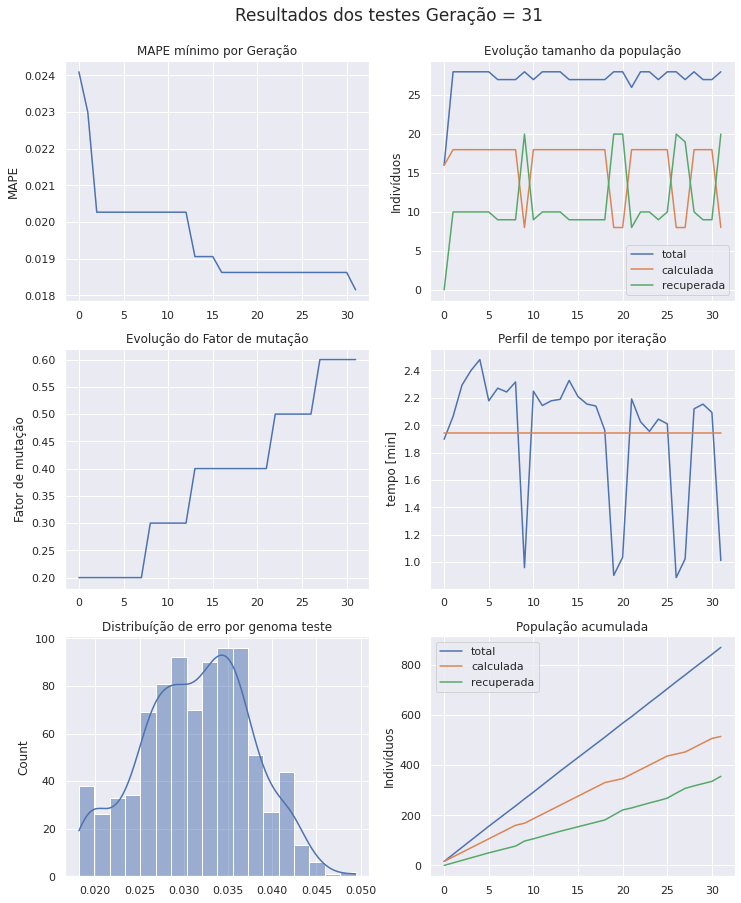

Parada por maximo de interações:  32
Menor Mape   0.018149456094201308
Código   [13 16 13 27  9 24  8 24 33 59 36 17 20]
Indice Mutação Final:  0.6
...########## 1 Comercial ####################
...
--># ep.0................................................................................................................._#0_min MAPE0.018351546451835364...
--># ep.1.............................................................................................................................................................._#1_min MAPE0.01810862104241138...
--># ep.2.............................................................................................................................................................._#2_min MAPE0.01810862104241138...
--># ep.3.........................................................................................................................................................._#3_min MAPE0.017604485882222683...
--># ep.4...............................

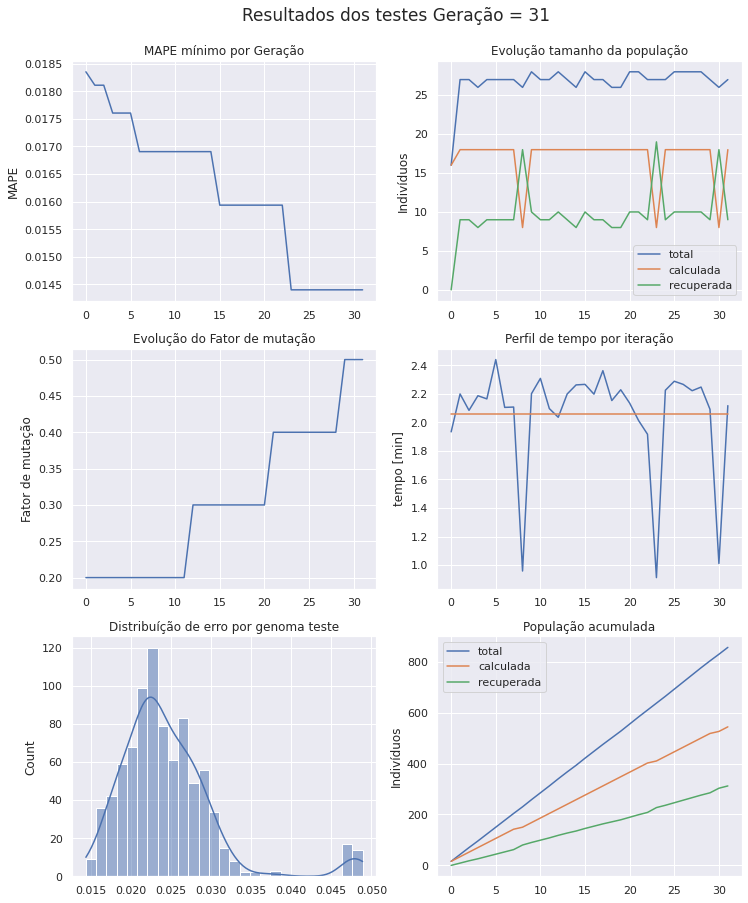

Parada por maximo de interações:  32
Menor Mape   0.014403090965084827
Código   [21 54 25 53 11 33 42 10  7 16 24  5 27]
Indice Mutação Final:  0.5
...########## 2 Industrial ####################
...
--># ep.0................................................................................................................._#0_min MAPE0.025522149245755934...
--># ep.1.........................................................................................................................................................._#1_min MAPE0.02509137880229942...
--># ep.2................................................................................................................................................_#2_min MAPE0.02476771422566267...
--># ep.3.................................................................................................................................................................._#3_min MAPE0.02476771422566267...
--># ep.4.........................................

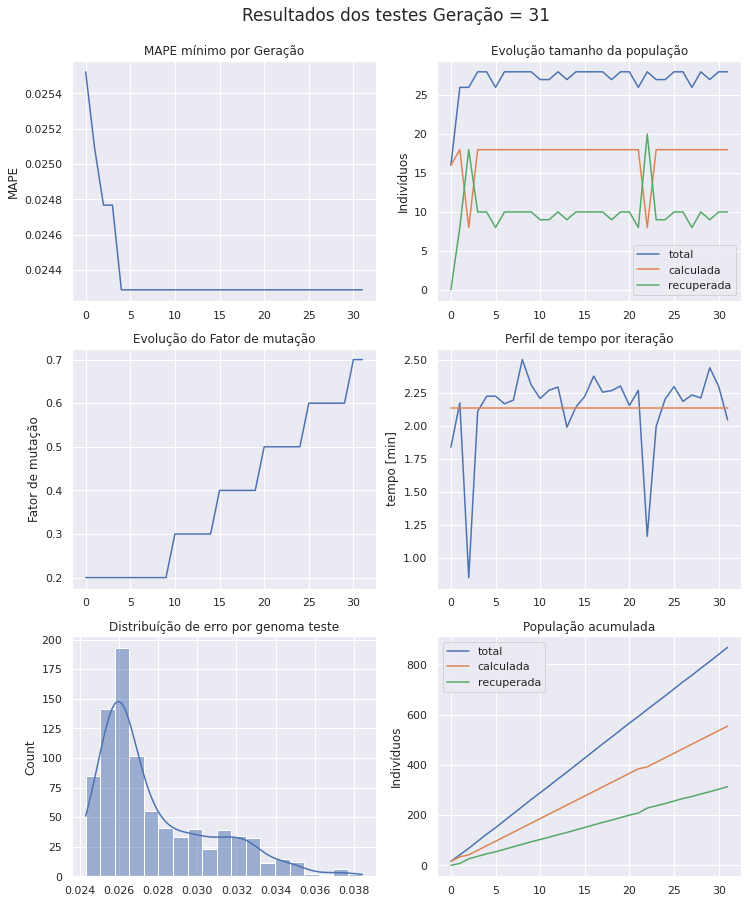

Parada por maximo de interações:  32
Menor Mape   0.024288498760796414
Código   [22 62 27 16 36 19  4  2 56 41 47 44 27]
Indice Mutação Final:  0.7
...########## 3 Residencial ####################
...
--># ep.0................................................................................................................._#0_min MAPE0.020934978470133397...
--># ep.1.............................................................................................................................................................._#1_min MAPE0.020934978470133397...
--># ep.2.............................................................................................................................................................._#2_min MAPE0.020934978470133397...
--># ep.3.................................................................................................................................................................._#3_min MAPE0.020934978470133397...
--># ep.4...................

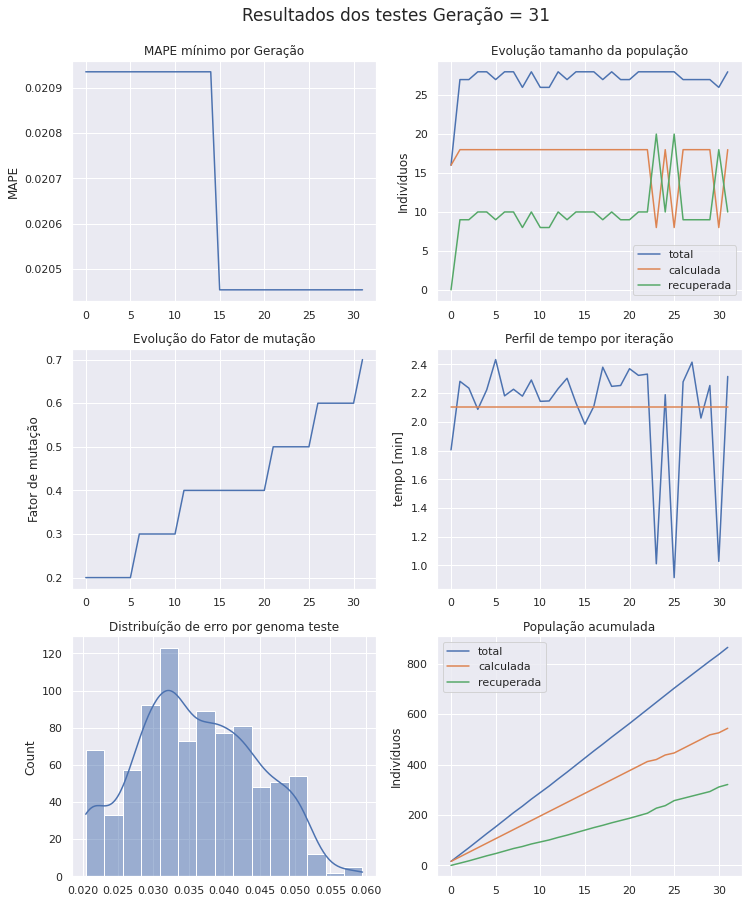

Parada por maximo de interações:  32
Menor Mape   0.0204543813903752
Código   [30 27 49 63 36 31 48 36  3 27 11 13 51]
Indice Mutação Final:  0.7
...########## 4 Outros ####################
...
--># ep.0................................................................................................................._#0_min MAPE0.03082265135367222...
--># ep.1.............................................................................................................................................................._#1_min MAPE0.020546055092017176...
--># ep.2.........................................................................................................................................................._#2_min MAPE0.020546055092017176...
--># ep.3.............................................................................................................................................................._#3_min MAPE0.020546055092017176...
--># ep.4...................................

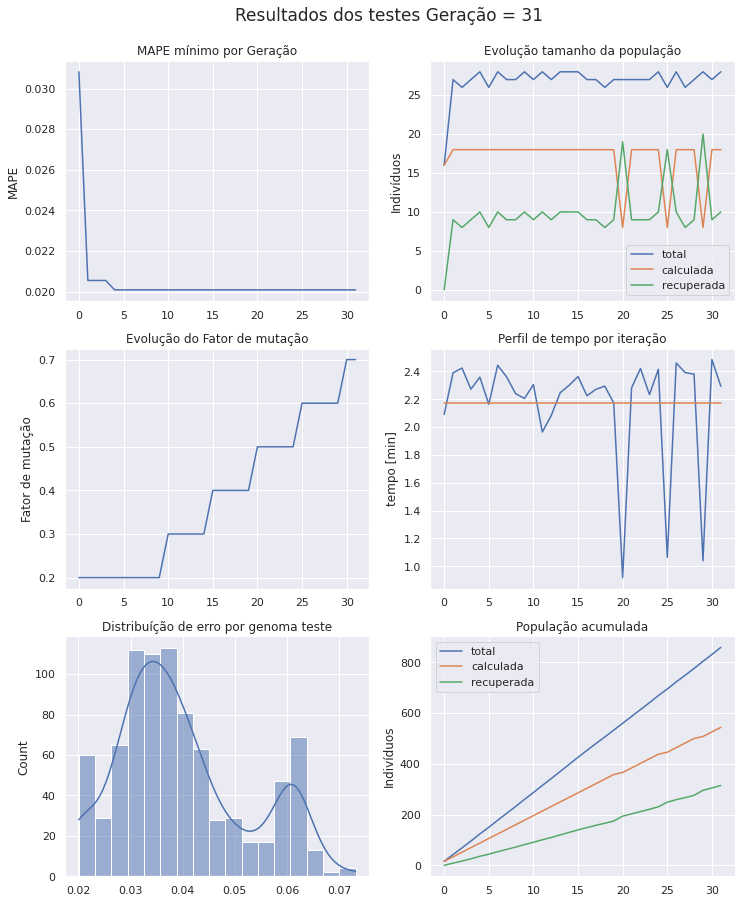

Parada por maximo de interações:  32
Menor Mape   0.020085040027526792
Código   [45  0 61  5 33 13  3 42 51 33 41 15 11]
Indice Mutação Final:  0.7
...CPU times: user 6h 31min 46s, sys: 23min 34s, total: 6h 55min 20s
Wall time: 5h 34min 14s


In [51]:
%%time
y_pred_list = []
mape_list = []
gen_list = []

for e,i in enumerate(Ycolumns):
    if 1:
        shape_in, shape_out, X_train, y_train, X_test, y_test, y_real, input_scaler, output_scaler = TrainTestData(e)
        print('#'*10, e, i, '#'*20)
        gen, mape = algoritmo_genetico(epocas=32, pop_tamanho=16)
        m_laco, _, y_laco = func_aptidao(gen)
        y_pred_list.append(y_laco)
        gen_list.append(gen)
        mape_list.append(m_laco)
mape_list.append(np.array(mape_list).mean())

# roda

# Comparativo Validação

In [52]:
#Relatório Manual agrupando os  resultados obtidos para cada SetorN1
if 0:
    list_mape = []
    list_gen = []

    ########## 0 Consumo 		####################
    list_mape.append(0.035652)
    list_gen.append(np.array([34, 58, 58, 14, 13,  7, 15,  1, 25, 26, 19, 37, 35])) 
    ########## 1 Comercial 		####################
    list_mape.append(0.088187)
    list_gen.append(np.array([29,  9, 13, 10, 58, 58, 13, 15, 59,  3, 50, 28,  3])) 
    ########## 2 Industrial 	####################
    list_mape.append(0.049014)
    list_gen.append(np.array([38, 19, 30,  7, 45, 41, 38, 58, 55,  6,  0, 25, 33])) 
    ########## 3 Residencial 	####################
    list_mape.append(0.014144)
    list_gen.append(np.array([20, 26, 49, 28, 31, 15,  0, 48, 58, 52, 23, 19, 11])) 
    ########## 4 Outros 		####################
    list_mape.append(0.024953)
    list_gen.append(np.array([57, 34,  1, 35, 59, 12, 57, 18, 48, 37, 39, 54, 60])) 

    list_mape.append(np.array(list_mape).mean())
    barras = [*Ycolumns, 'Média']

    plt_barras(barras,list_mape)

In [53]:
Ycolumns

['Consumo', 'Comercial', 'Industrial', 'Residencial', 'Outros']

In [54]:
y_pred_list = []
mape_list = []

for e,i in enumerate(Ycolumns):
    if 1:
        shape_in, shape_out, X_train, y_train, X_test, y_test, y_real, input_scaler, output_scaler = TrainTestData(e)
        print('\n'+('#'*10), e, i, ' '*(20-len(i))+'#'*20)
        m_laco, _, y_laco = func_aptidao(gen_list[e])
        y_pred_list.append(y_laco)
        mape_list.append(m_laco)
mape_list.append(np.array(mape_list).mean())


########## 0 Consumo              ####################
...
########## 1 Comercial            ####################
...
########## 2 Industrial           ####################
...
########## 3 Residencial          ####################
...
########## 4 Outros               ####################
...

In [55]:
X,y,input_scaler,output_scaler,X_train,y_train,X_test,y_test,y_real,shape_in, shape_out = TrainTestData_old()

In [56]:
y_pred_list = np.array(y_pred_list).reshape(5,12)

0 Consumo
1 Comercial
2 Industrial
3 Residencial
4 Outros


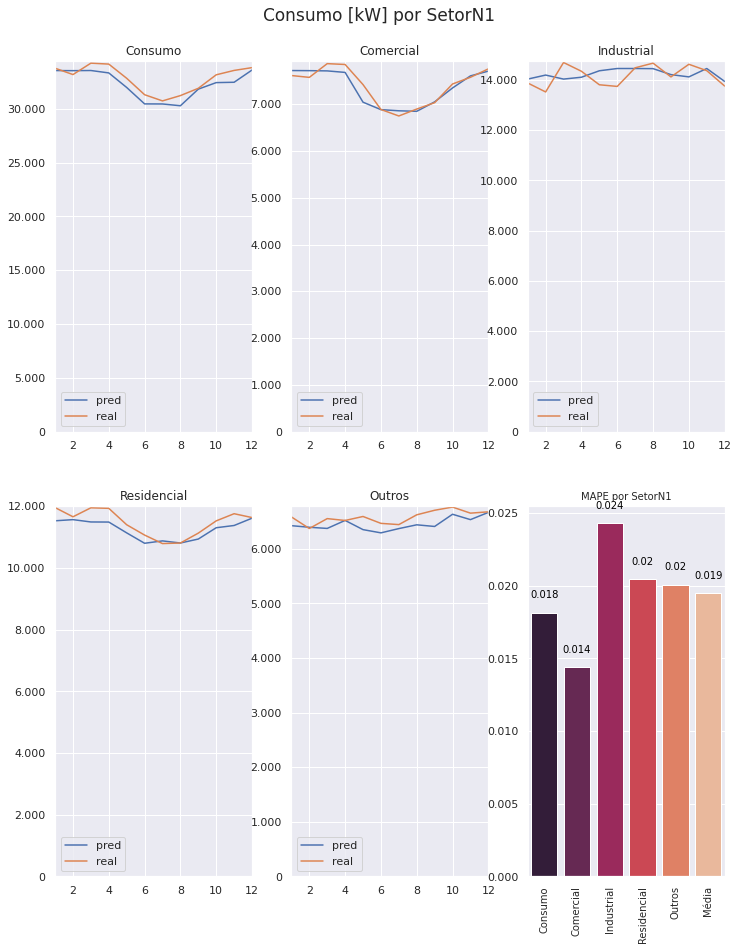

In [57]:
plt_perfis_de_consumo2(y_pred_list.T)

#Fim

0 Consumo
1 Comercial
2 Industrial
3 Residencial
4 Outros


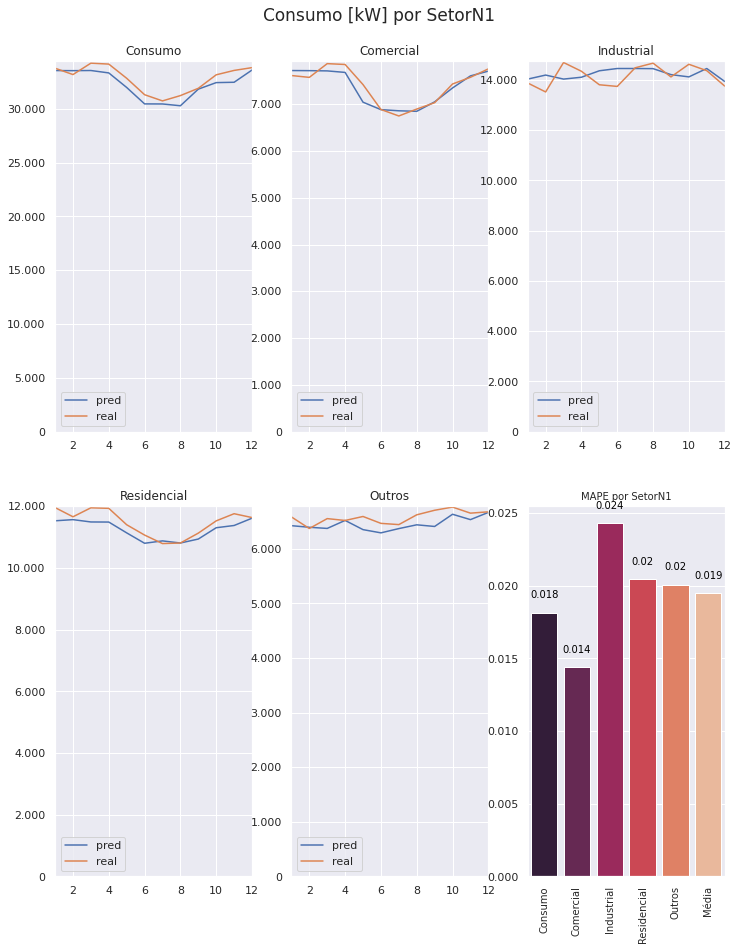

In [58]:
#def plt_perfis_de_consumo2(yp = y_pred_list.T):
if 1: 
    yp = y_pred_list.T
    list_mape = []

    fig, axs = plt.subplots(2,3, figsize=(12,15))
    for e, i in enumerate(y.columns):
        if e < 3:
            s = 0
        elif e < 6: 
            s = 1
        else:
            s = 2
        print(e, i)
        sns.lineplot(ax=axs[s,e-s*3],x=range(1,13),y=yp[-12:,e]/1000, label = 'pred')
        sns.lineplot(ax=axs[s,e-s*3],x=range(1,13),y=y.iloc[-12:,e]/1000, label = 'real')
        axs[s,e-s*3].set_title(i)
        axs[s,e-s*3].set_xlabel('')
        axs[s,e-s*3].set_ylabel('')
        #axs[s,e-s*3].set_ylim(0,3_000_000)
        axs[s,e-s*3].set_ylim(0)
        axs[s,e-s*3].set_xticks(range(0,13,2))
        axs[s,e-s*3].set_xlim(1, 12)
        axs[s,e-s*3].yaxis.set_major_formatter(ticker.FuncFormatter(formatador_de_milhares))
        mape = mean_absolute_percentage_error(y.iloc[-12:,e],yp[:,e])
        list_mape.append(mape)
    list_mape.append(np.array(list_mape).mean())

    plt.suptitle('Consumo [kW] por SetorN1' , y=.93, fontsize=17)
    y_bars = [*y.columns,'Média']
    g = sns.barplot(ax=axs[1,2], x=y_bars, y=list_mape, palette='rocket')
    for i in range(len(y_bars)):
        g.text(i,list_mape[i]+0.001, round(list_mape[i],3), color='black', ha="center", fontsize=10)
    plt.xticks(rotation = 90, fontsize=10)
    plt.title('MAPE por SetorN1', fontsize = 10)

    plt.show()
    ;